# Customizing LayoutParser Models with Label Studio Annotation
*With Scientific Document Parsing as an example*

## Prerequisite

This tutorial assumes you know about

- Intermediate Python  

## Introduction

### Objectives & Task Overview

Please see the attached slides [here](https://szj.io/assets/files/talks/2022-Feb-LayoutParser-and-Label-Studio-Webinar.pdf).

### Detailed Steps

1. **Define the problem**
    - What is the extraction target?
    - What can existing models do?
    - Do we have available dataset?
2. **Create the Training Dataset**
    - Obtain the datasets
    - Set up Label Studio
    - Define the Annotation Schema  
    - Annotate and Save
3. **Train Layout Models**
    - Set up the Machines
    - Train Test Split
    - Run the LayoutPaser Model Training script
4. **Utilize New Layout Models**
    - Load Layout Models
    - Parse the outputs based on Layout Models

## I. Define the Problem

### Extraction Target

Bibliogrophy item parsing is an important task in scientific document understanding. We want to extract individual bibliogrophy items from the source documents. For example, for the page on the left, we'd like to segment it into "blocks" shown on the right.

![task-overview.png](https://github.com/sidiex/layout-parser/blob/main/examples/Customizing%20Layout%20Models%20with%20Label%20Studio%20Annotation/task-overview.png?raw=1)

### Existing Models

The PubLayNet models maybe the most straightfoward ones to try with:

In [5]:
!pip install "layoutparser[ocr]" # Install OCR toolkit
import requests
import layoutparser as lp

In [6]:
# Download a test PDF
r = requests.get("https://arxiv.org/pdf/2106.00676.pdf")
with open("test.pdf", 'wb') as fp:
    fp.write(r.content)

In [7]:
!sudo apt-get update
!sudo apt-get install poppler-utils
pdf_tokens, pdf_images = lp.load_pdf("test.pdf", load_images=True)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

Find a model from the [LayoutParser Open Platform](https://layout-parser.github.io/platform/)

In [12]:
!pip install effdet
model = lp.AutoLayoutModel("lp://efficientdet/PubLayNet/tf_efficientdet_d0")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.5/112.5 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   

ImportError: 
EfficientDetLayoutModel requires the effdet library but it was not found in your environment. You can install it with pip:
`pip install effdet`


In [ ]:
layout = model.detect(pdf_images[11]) # The page with reference

In [ ]:
lp.draw_box(pdf_images[11], layout)

### Existing Datasets?

:(

## II. Create a Training Dataset

### Obtain the Source Data


### Set up Label Studio

Please follow the instructions on the [Label Studio Github Repo](https://github.com/heartexlabs/label-studio). I used the following configurations for setting up the annotation task.

```bash
# Installation
git clone https://github.com/heartexlabs/label-studio.git
pip install -e .

# Starting the service
python label_studio/manage.py migrate
python label_studio/manage.py runserver
```

After starting Label Studio on your local machine, you can click [here](http://localhost:8080/) for the running service.

Also here is the used labelstudio interface config:

```html
<View style="display: flex;">
  <View style="width: 600px">
    <Image name="image" value="$image"/>
  </View>
  
  <View style="width: 150px; padding: 0 1em; margin-right: 0.5em; background: #f1f1f1; border-radius: 3px">
  <RectangleLabels name="label" toName="image">
    <Label value="BibItem" background="#FFA39E"></Label>
  </RectangleLabels>
  </View>
</View>
```

### Downlaod the Annotation Examples  

You can run `download_annotation.py` in this folder to download the annotation data:

```bash
# pip install layoutparser
python download_annotation.py
```

It will download a small subset of data for demostration purpose, and you might need to label more samples in practice to train a better model.

### Check the Annotated Data

The script is based on this [layout parser example tutorial](https://layout-parser.readthedocs.io/en/latest/example/load_coco/index.html).

In [1]:
from pycocotools.coco import COCO
import layoutparser as lp
import random
import cv2

def load_coco_annotations(annotations, coco=None):
    """
    Args:
        annotations (List):
            a list of coco annotaions for the current image
        coco (`optional`, defaults to `False`):
            COCO annotation object instance. If set, this function will
            convert the loaded annotation category ids to category names
            set in COCO.categories
    """
    layout = lp.Layout()

    for ele in annotations:

        x, y, w, h = ele['bbox']

        layout.append(
            lp.TextBlock(
                block = lp.Rectangle(x, y, w+x, h+y),
                type  = ele['category_id'] if coco is None else coco.cats[ele['category_id']]['name'],
                id = ele['id']
            )
        )

    return layout

In [4]:
!wget https://raw.githubusercontent.com/Layout-Parser/layout-parser/refs/heads/main/examples/Customizing%20Layout%20Models%20with%20Label%20Studio%20Annotation/download_annotation.py
!python download_annotation.py
COCO_ANNO_PATH = 'downloaded-annotations/result.json'
COCO_IMG_PATH  = 'downloaded-annotations/'

coco = COCO(COCO_ANNO_PATH)

--2025-04-11 04:19:22--  https://raw.githubusercontent.com/Layout-Parser/layout-parser/refs/heads/main/examples/Customizing%20Layout%20Models%20with%20Label%20Studio%20Annotation/download_annotation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1771 (1.7K) [text/plain]
Saving to: ‘download_annotation.py.1’

download_annotation 100%[===================>]   1.73K  --.-KB/s    in 0s      

2025-04-11 04:19:22 (29.1 MB/s) - ‘download_annotation.py.1’ saved [1771/1771]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


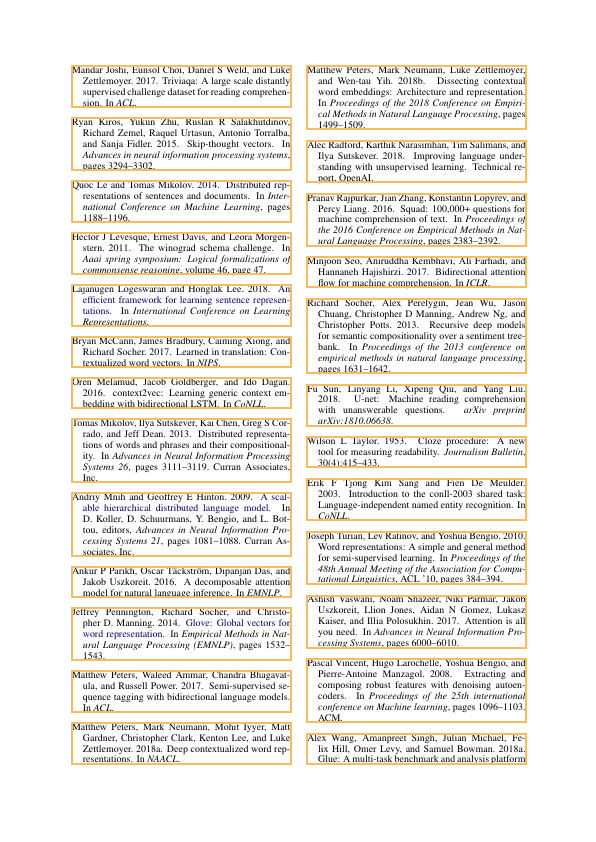

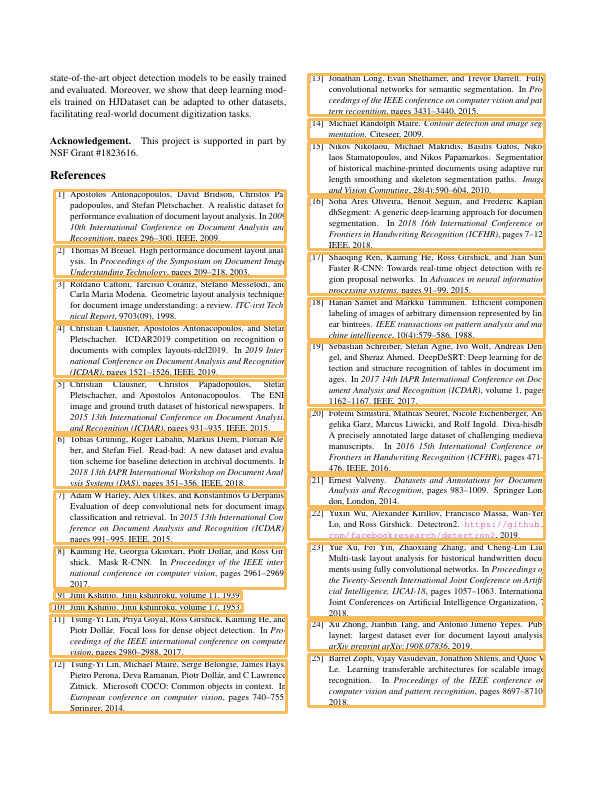

In [6]:
for image_id in random.sample(list(coco.imgs.keys()), 2):
    image_info = coco.imgs[image_id]
    annotations = coco.loadAnns(coco.getAnnIds([image_id]))

    image = cv2.imread(f'{COCO_IMG_PATH}/{image_info["file_name"]}')
    layout = load_coco_annotations(annotations, coco)

    viz = lp.draw_box(image[...,::-1], layout)
    display(viz) # show the results

### [Optional] Define the Annotation Schema

- Rethink why models are needed?
- Labeling Schema
  - Go through examples
    - Gather >30 diverse examples from the task
    - Go through them and take notes
      - Keep an eye on what are the uniquely different types of segments to be predicted?
  - Define the classes
    - Write definition based on visual features as clear as you can
      - Good example:
        - The title block should be a short piece of bold text; it usually have one line or two; it usually appear at the first page of the document
      - Bad example:
        - Annotate the document title region as a title block
    - Add image examples
      - If possible, also include ambiguous or counter examples

### [Optional] Advanced Topic: Active Learning

You can find more about this topic in [our recent paper](https://arxiv.org/pdf/2010.01762.pdf).

## III. Layout Model Training

```bash
git clone git@github.com:Layout-Parser/layout-model-training.git
```

In [11]:
!git clone https://github.com/Layout-Parser/layout-model-training.git

Cloning into 'layout-model-training'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121 (from 1)
Receiving objects: 100% (121/121), 29.50 KiB | 5.90 MiB/s, done.
Resolving deltas: 100% (62/62), done.


### Train-Test Split

```bash
python cocosplit.py \                                  
    --annotation-path     ../data/bib/result.json \
    --split-ratio         0.85 \
    --train               ../data/bib/train.json \
    --test                ../data/bib/test.json
```

In [18]:
!pwd
!python cocosplit.py \ --annotation-path     ../data/bib/result.json \  --split-ratio         0.85 \ --train               ../data/bib/train.json \    --test                ../data/bib/test.json

/content
python3: can't open file '/content/cocosplit.py': [Errno 2] No such file or directory


### Run Training

1. Modify the `train_bib.sh` script
2. Run the following command

    ```bash
    bash train_bib.sh
    ```

## IV. Use of the Layout Models

### Load Newly Trained Layout Models

In [ ]:
model = lp.Detectron2LayoutModel(
    config_path = "layout-model-training/outputs/bib/fast_rcnn_R_50_FPN_3x/config.yaml",
    model_path = "layout-model-training/outputs/bib/fast_rcnn_R_50_FPN_3x/model_final.pth",
    extra_config = ["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8] # <-- Only output high accuracy preds
)

In [ ]:
layout = model.detect(pdf_images[11])

In [ ]:
lp.draw_box(pdf_images[11], layout)

In [ ]:
# Download another PDF
r = requests.get("https://arxiv.org/pdf/2004.07180.pdf")
with open("test2.pdf", 'wb') as fp:
    fp.write(r.content )

pdf_tokens, pdf_images = lp.load_pdf("test2.pdf", load_images=True)

In [ ]:
layout = model.detect(pdf_images[8])
lp.draw_box(pdf_images[8], layout)

In [ ]:
layout = model.detect(pdf_images[9])
lp.draw_box(pdf_images[9], layout)

### Parse Structured Data from Documents

In [ ]:
for page_index in [8, 9, 10]: #Reference Section
    bib_items = model.detect(pdf_images[page_index])
    break

In [ ]:
for bib_item in bib_items:
    bib_tokens = pdf_tokens[page_index].filter_by(bib_item, center=True)
    break

Check what's inside each bib_item block?

In [ ]:
viz = lp.draw_box(pdf_images[page_index], bib_tokens, color_map={}, box_alpha=0.2, box_width=0)
viz

In [ ]:
lp.draw_box(viz, [bib_item], color_map={}) # <- Overlay bib-item block tokens onto bib_tokens

In [ ]:
" ".join(bib_tokens.get_texts())

Combin them together:

In [ ]:
from collections import defaultdict
pdf_bibs = defaultdict(list)

for page_index in [8, 9, 10]: # Reference Section
    bib_items = model.detect(pdf_images[page_index])
    display(lp.draw_box(pdf_images[page_index], bib_items))

    for bib_item in bib_items:
        bib_tokens = pdf_tokens[page_index].filter_by(bib_item, center=True)
        bib_text = " ".join(bib_tokens.get_texts())
        pdf_bibs[page_index].append(bib_text)

In [ ]:
import pandas as pd

(pd
 .DataFrame(tuple(pdf_bibs.items()),
             columns=['page_index', 'bib-item'])
 .explode('bib-item')
 .reset_index(drop=True)
)

### Incorrect order of bib items -- Can we do better?

In [ ]:
pdf_tokens[0][1].id

In [ ]:
pdf_bibs = {}

for page_index in [8, 9, 10]: #Reference Section
    bib_items = model.detect(pdf_images[page_index])

    page_bib_tokens = []
    for bib_item in bib_items:
        bib_tokens = pdf_tokens[page_index].filter_by(bib_item, center=True)
        page_bib_tokens.append(bib_tokens)

    page_bib_tokens = sorted(page_bib_tokens, key=lambda tokens: min([ele.id for ele in tokens]))
    # Sort them using PDF Token Indices

    pdf_bibs[page_index] = [" ".join(bib_tokens.get_texts()) for bib_tokens in page_bib_tokens]

In [ ]:
lp.draw_box(pdf_images[page_index], bib_items, show_element_id=True, id_font_size=12)

In [ ]:
(pd
 .DataFrame(tuple(pdf_bibs.items()),
             columns=['page_index', 'bib-item'])
 .explode('bib-item')
 .reset_index(drop=True)
)[:10]

In [ ]:
pdf_images[9]